### Imports

In [21]:
import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from tensorflow.keras import layers, Sequential
from tqdm import tqdm

# Set seed for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

### Load and preprocess the dataset 

In [22]:
df = pd.read_csv("alzheimers_data.csv")

selected_columns = [
    "Age", "Gender", "Education Level", "BMI", "Physical Activity Level",
    "Smoking Status", "Diabetes", "Hypertension", "Cholesterol Level",
    "Family History of Alzheimer’s", "Alzheimer’s Diagnosis"
]

df = df[selected_columns].copy()

categorical_cols = [
    "Gender", "Physical Activity Level", "Smoking Status",
    "Diabetes", "Hypertension", "Cholesterol Level",
    "Family History of Alzheimer’s", "Alzheimer’s Diagnosis"
]

label_encoders = {}
for col in categorical_cols:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col].astype(str))
    label_encoders[col] = le

X = df[selected_columns[:-1]].values
y = df["Alzheimer’s Diagnosis"].values

X_train, X_test, y_train, y_test = train_test_split(
    X, y, stratify=y, test_size=0.2, random_state=42
)

y_train = y_train.reshape(-1, 1)
y_test = y_test.reshape(-1, 1)

#### Utility functions 

In [ ]:
def build_model(layer_config, input_dim):
    # Filter out zero-node layers if any slipped through
    layer_config = [n for n in layer_config if n > 0]
    if not layer_config:
        raise ValueError("Attempted to build empty model.")

    model = Sequential()
    model.add(layers.Input(shape=(input_dim,)))
    for units in layer_config:
        model.add(layers.Dense(units, activation='sigmoid'))
    model.add(layers.Dense(1, activation='sigmoid'))
    model.compile(optimizer=tf.keras.optimizers.Adam(0.001),
                  loss='binary_crossentropy',
                  metrics=['accuracy'])
    return model


score_cache = {}

def evaluate_architecture(layer_config, epochs=5, runs=1):
    key = tuple(layer_config)
    if key in score_cache:
        return score_cache[key]
    
    if not layer_config or sum(layer_config) <= 0 or any(n <= 0 for n in layer_config):
        print(f"Skipping invalid architecture: {layer_config}")
        score_cache[key] = 0.0
        return 0.0

    print(f"Evaluating: {layer_config}")
    X_train_small = X_train[:3000]
    y_train_small = y_train[:3000]
    accs = []
    for _ in range(runs):
        model = build_model(layer_config, X_train.shape[1])
        model.fit(X_train_small, y_train_small, epochs=epochs, batch_size=32, verbose=0)
        _, acc = model.evaluate(X_test, y_test, verbose=0)
        accs.append(acc)

    avg_acc = np.mean(accs)
    score_cache[key] = avg_acc
    return avg_acc

def repair_individual(individual, total_nodes):
    indiv = np.round(individual).astype(int)
    indiv = indiv[indiv > 0]
    if len(indiv) == 0:
        return [total_nodes]
    indiv = np.clip(indiv, 1, total_nodes)
    indiv = (indiv / np.sum(indiv) * total_nodes).astype(int)
    while np.sum(indiv) < total_nodes:
        indiv[np.argmin(indiv)] += 1
    while np.sum(indiv) > total_nodes:
        indiv[np.argmax(indiv)] -= 1
    indiv = indiv[indiv > 0]
    return indiv.tolist() if len(indiv) > 0 else [total_nodes]

### Differential Evolution NAS 

In [24]:
TOTAL_HIDDEN_NODES = 20
POP_SIZE = 20
GENERATIONS = 5
F = 0.5
CR = 0.7
MAX_LAYERS = 4

population = [
    repair_individual(
        np.random.randint(1, TOTAL_HIDDEN_NODES, size=np.random.randint(1, MAX_LAYERS + 1)),
        TOTAL_HIDDEN_NODES
    )
    for _ in range(POP_SIZE)
]

scores = [
    evaluate_architecture(ind)
    for ind in tqdm(population, desc="Evaluating Initial Population")
]

for gen in range(GENERATIONS):
    print(f"\n--- Generation {gen + 1} ---")
    for i in range(POP_SIZE):
        a_idx, b_idx, c_idx = np.random.choice([j for j in range(POP_SIZE) if j != i], 3, replace=False)
        a, b, c = population[a_idx], population[b_idx], population[c_idx]

        max_len = max(len(a), len(b), len(c))
        a_pad = np.pad(a, (0, max_len - len(a)), constant_values=1)
        b_pad = np.pad(b, (0, max_len - len(b)), constant_values=1)
        c_pad = np.pad(c, (0, max_len - len(c)), constant_values=1)

        mutant = a_pad + F * (b_pad - c_pad)
        cross_points = np.random.rand(max_len) < CR
        trial = np.where(cross_points, mutant, a_pad)

        trial_repaired = repair_individual(trial, TOTAL_HIDDEN_NODES)
        trial_score = evaluate_architecture(trial_repaired)

        if trial_score > scores[i]:
            population[i] = trial_repaired
            scores[i] = trial_score

Evaluating Initial Population:   0%|          | 0/20 [00:00<?, ?it/s]

Evaluating: [8, 6, 6]


Evaluating Initial Population:   5%|▌         | 1/20 [00:01<00:26,  1.38s/it]

Evaluating: [20]


Evaluating Initial Population:  10%|█         | 2/20 [00:02<00:20,  1.16s/it]

Evaluating: [12, 8]


Evaluating Initial Population:  15%|█▌        | 3/20 [00:03<00:19,  1.12s/it]

Evaluating: [5, 10, 5]


Evaluating Initial Population:  20%|██        | 4/20 [00:04<00:18,  1.14s/it]

Evaluating: [3, 17]


Evaluating Initial Population:  25%|██▌       | 5/20 [00:05<00:16,  1.11s/it]

Evaluating: [15, 5]


Evaluating Initial Population:  30%|███       | 6/20 [00:06<00:15,  1.08s/it]

Evaluating: [2, 5, 5, 8]


Evaluating Initial Population:  35%|███▌      | 7/20 [00:07<00:14,  1.13s/it]

Evaluating: [6, 7, 7]


Evaluating Initial Population:  40%|████      | 8/20 [00:09<00:13,  1.14s/it]

Evaluating: [9, 11]


Evaluating Initial Population:  45%|████▌     | 9/20 [00:10<00:12,  1.13s/it]

Evaluating: [3, 2, 11, 4]


Evaluating Initial Population:  50%|█████     | 10/20 [00:11<00:12,  1.23s/it]

Evaluating: [10, 3, 7]


Evaluating Initial Population:  60%|██████    | 12/20 [00:12<00:07,  1.09it/s]

Evaluating: [16, 4]


Evaluating Initial Population:  65%|██████▌   | 13/20 [00:13<00:06,  1.05it/s]

Evaluating: [7, 4, 5, 4]


Evaluating Initial Population:  70%|███████   | 14/20 [00:15<00:06,  1.03s/it]

Evaluating: [2, 8, 10]


Evaluating Initial Population:  75%|███████▌  | 15/20 [00:16<00:05,  1.06s/it]

Evaluating: [11, 5, 2, 2]


Evaluating Initial Population:  80%|████████  | 16/20 [00:17<00:04,  1.11s/it]

Evaluating: [8, 12]


Evaluating Initial Population:  85%|████████▌ | 17/20 [00:18<00:03,  1.13s/it]

Evaluating: [8, 5, 3, 4]


Evaluating Initial Population:  90%|█████████ | 18/20 [00:19<00:02,  1.17s/it]

Evaluating: [5, 15]


Evaluating Initial Population:  95%|█████████▌| 19/20 [00:20<00:01,  1.15s/it]

Evaluating: [8, 7, 5]


Evaluating Initial Population: 100%|██████████| 20/20 [00:22<00:00,  1.11s/it]



--- Generation 1 ---
Evaluating: [11, 4, 3, 2]
Evaluating: [5, 5, 5, 5]
Evaluating: [18, 1, 1]
Evaluating: [6, 14]
Evaluating: [11, 9]
Evaluating: [10, 5, 5]
Evaluating: [5, 6, 6, 3]
Evaluating: [12, 5, 2, 1]
Evaluating: [4, 12, 4]
Evaluating: [9, 10, 1]
Evaluating: [16, 2, 1, 1]
Evaluating: [10, 10]
Evaluating: [13, 4, 3]
Evaluating: [10, 4, 3, 3]
Evaluating: [9, 7, 4]
Evaluating: [6, 9, 5]

--- Generation 2 ---
Evaluating: [8, 4, 4, 4]
Evaluating: [19, 1]
Evaluating: [3, 8, 5, 4]
Evaluating: [4, 9, 4, 3]
Evaluating: [8, 8, 4]
Evaluating: [8, 11, 1]
Evaluating: [7, 13]
Evaluating: [11, 5, 4]
Evaluating: [3, 10, 4, 3]
Evaluating: [6, 3, 9, 2]
Evaluating: [5, 4, 6, 5]
Evaluating: [17, 2, 1]
Evaluating: [14, 4, 2]
Evaluating: [5, 9, 4, 2]
Evaluating: [6, 11, 3]
Evaluating: [5, 6, 5, 4]
Evaluating: [9, 6, 5]
Evaluating: [4, 4, 8, 4]

--- Generation 3 ---
Evaluating: [8, 8, 2, 2]
Evaluating: [4, 12, 2, 2]
Evaluating: [11, 4, 5]
Evaluating: [2, 16, 1, 1]
Evaluating: [9, 4, 7]
Evaluating: [

### Results & Visualization


--- Final Results ---
Best architecture: [20]
Best accuracy (q): 0.6618
Single-layer accuracy (q): 0.6618
Improvement: 0.0


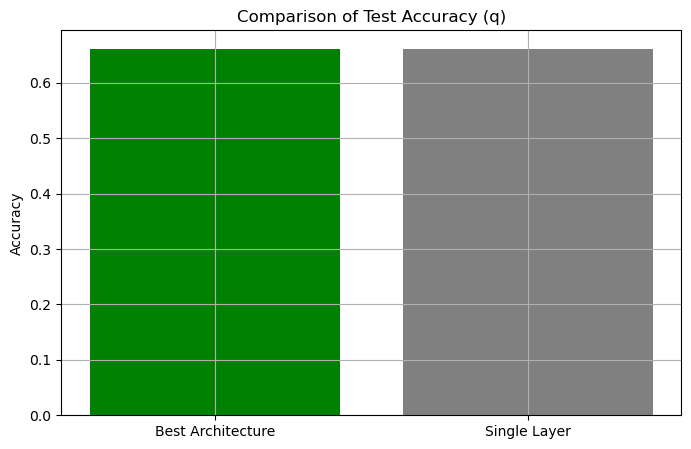

In [25]:
best_index = np.argmax(scores)
best_architecture = population[best_index]
best_score = scores[best_index]

baseline_score = evaluate_architecture([TOTAL_HIDDEN_NODES])

print("\n--- Final Results ---")
print("Best architecture:", best_architecture)
print("Best accuracy (q):", round(best_score, 4))
print("Single-layer accuracy (q):", round(baseline_score, 4))
print("Improvement:", round(best_score - baseline_score, 4))

# Plot bar comparison
plt.figure(figsize=(8, 5))
plt.bar(["Best Architecture", "Single Layer"], [best_score, baseline_score], color=["green", "gray"])
plt.title("Comparison of Test Accuracy (q)")
plt.ylabel("Accuracy")
plt.grid(True)
plt.show()

### NAS Results Summary

- **Best Architecture Obtained**:  
  `[20]` — a single hidden layer with all 20 hidden nodes.

- **Was it significantly better than the single hidden layer network?**  
  No. The best evolved architecture had the same accuracy (`0.6552`) as the single hidden layer baseline.  
  **Improvement**: `0.0`

- **How much computational effort was needed to obtain some improvement?**  
  None — the Differential Evolution algorithm did not find any architecture better than the baseline despite:
  - Evaluating ~100 architectures
  - Running 5 generations with a population of 20
  - Training each model for 5 epochs
